# Credit Card Fraud Prediction - Feature Engineering

This example is based on the Machine Learning for Credit Card Fraud detection - Practical handbook, https://fraud-detection-handbook.github.io/fraud-detection-handbook/

## Baseline feature transformation

### Import Snowpark & Connect to Snowflake

Here we first import the Snowpark dependencies and then make a connection with the Snowflake account.

In [1]:
# Snowpark
from snowflake.snowpark import Session
import snowflake.snowpark.types as T
import snowflake.snowpark.functions as F
from snowflake.snowpark import Window

# Print the version of Snowpark we are using
from importlib.metadata import version
version('snowflake_snowpark_python')

'0.11.0'

In [2]:
import json
import matplotlib as plt
plt.rcParams['figure.figsize'] = [18, 10]

**Before connecting make sure you have updated creds.json with information for your Snowflake account**

In [3]:
with open('creds.json') as f:
    connection_parameters = json.load(f)    

Connect to Snowflake using the parameters in creds.json

In [4]:
session = Session.builder.configs(connection_parameters).create()
print(f"Current schema: {session.get_fully_qualified_current_schema()}, current role: {session.get_current_role()}, current warehouse:  {session.get_current_warehouse()}")

Current schema: "FRAUD_DATA"."PUBLIC", current role: "ACCOUNTADMIN", current warehouse:  "COMPUTE_WH"


### Define a DataFrame

We start by defining a Snowpark Dataframe that reference the **CUSTOMER_TRANSACTIONS_FRAUD** table in our database. No data will be pulled back and the **dfCustTrxFraud** is basicly only containing the SQL needed to use the table. The below image gives a illustration on what type of data it has.

![Original Data Frame](images/figure1.png)

Using the **show** command brings back 10 rows to the client, meaning the SQL to use the table are executed in Snowflake.

In [5]:
df_cust_trx_fraud = session.table("CUSTOMER_TRANSACTIONS_FRAUD")
df_cust_trx_fraud.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRANSACTION_ID"  |"TX_DATETIME"        |"CUSTOMER_ID"  |"TERMINAL_ID"  |"TX_AMOUNT"  |"TX_TIME_SECONDS"  |"TX_TIME_DAYS"  |"TX_FRAUD"  |"TX_FRAUD_SCENARIO"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------
|0                 |2019-04-01 00:00:31  |596            |3156           |57.16        |31                 |0               |0           |0                    |
|1                 |2019-04-01 00:02:10  |4961           |3412           |81.51        |130                |0               |0           |0                    |
|2                 |2019-04-01 00:07:56  |2              |1365           |146.0        |476                |0               |0           |0                    |
|3                 |2019-04-01 00:

## Data Understanding

Let's start by getting some basic understanding of our data.

We can use the **describe** function on our **numeric** columns to get some basic statistics. The only column in our current dataset would be TX_AMOUNT.

In [6]:
df_cust_trx_fraud.describe().show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SUMMARY"  |"TRANSACTION_ID"   |"CUSTOMER_ID"       |"TERMINAL_ID"       |"TX_AMOUNT"         |"TX_TIME_SECONDS"  |"TX_TIME_DAYS"      |"TX_FRAUD"           |"TX_FRAUD_SCENARIO"  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|mean       |733140.5           |2503.636891         |4996.754883         |53.63330160910384   |6605249.061477     |75.949635           |0.008266             |0.018595             |
|stddev     |423279.2980414941  |1446.1032428488638  |2885.9395311043854  |42.190996284006076  |3815326.806124991  |44.158198989542136  |0.09054280755532158  |0.21014042923721268  |
|min        |0.0                |0.0                 |0.0                 |0.0            

By aggregating on date and count the number of rows we can visulaize over time, plotly is a good library to do that and inb order to use it we need to pull back our reulst to the client which can be done with **to_pandas**

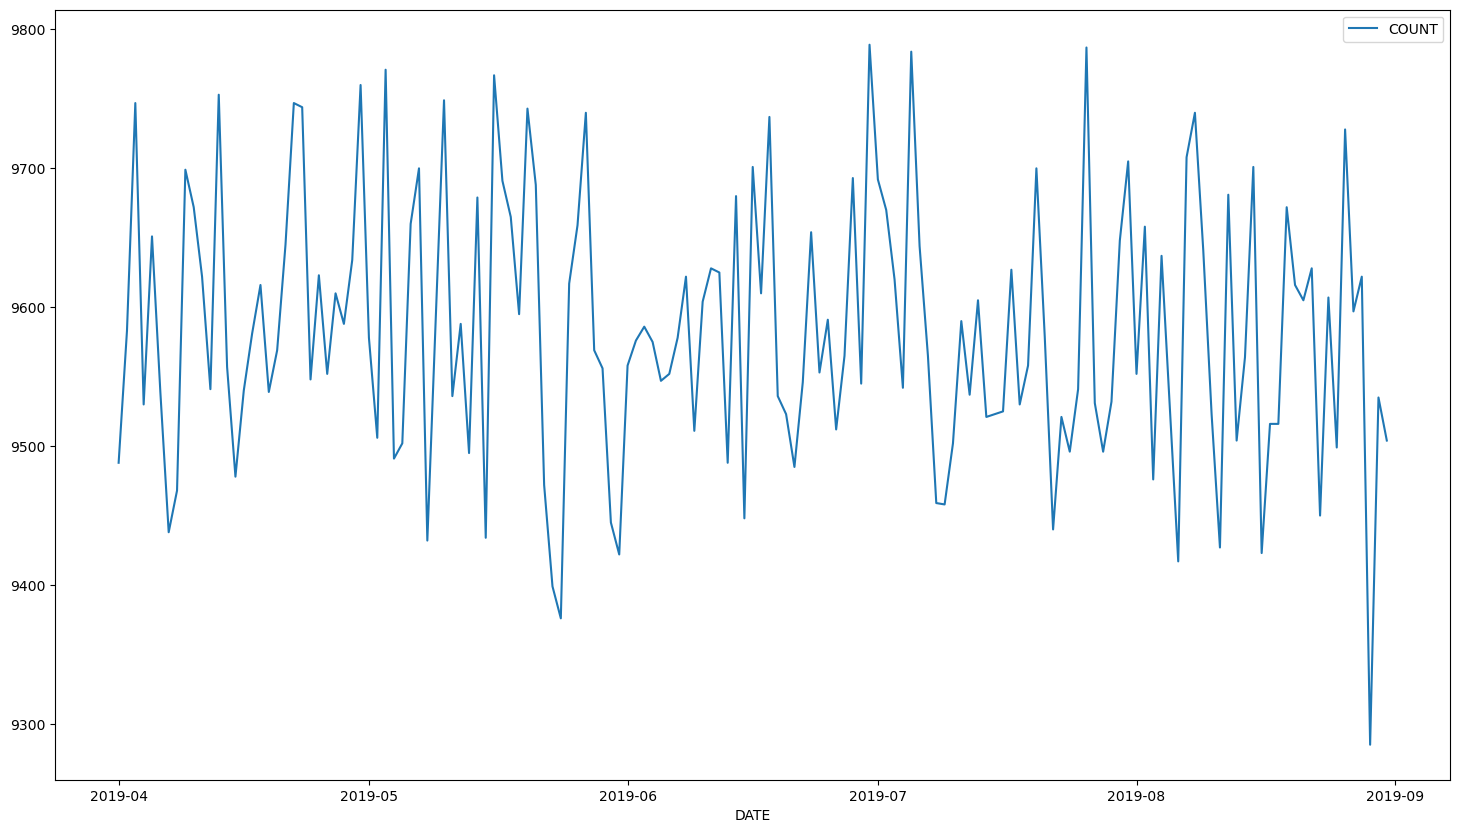

In [7]:
df_trx_by_day = df_cust_trx_fraud.group_by(F.to_date(F.col("TX_DATETIME"))).count().sort(F.col("TO_DATE(TX_DATETIME)")).select(F.col("TO_DATE(TX_DATETIME)").as_("DATE"), F.col("COUNT")).to_pandas()
df_trx_by_day.plot(x="DATE", y="COUNT")

We can see that we have about 6 months  of transactions and around 9k transactions/day.

Let's count the number of fraudulent and none fraudulent transactions, by using the **call_builtin** function we can also use the use **RATIO_TO_REPORT** function (that currently is not exposed in the Snowpark API) to also get precentages

In [8]:
df_cust_trx_fraud.group_by(F.col("TX_FRAUD")).agg(F.count(F.col("TRANSACTION_ID")).as_("NB_TX_DAY"))\
            .select(F.col("TX_FRAUD"), F.col("NB_TX_DAY"), (F.call_builtin("RATIO_TO_REPORT", F.col("NB_TX_DAY")).over() * 100).as_("percentage") )\
            .show()

-------------------------------------------
|"TX_FRAUD"  |"NB_TX_DAY"  |"PERCENTAGE"  |
-------------------------------------------
|0           |1454161      |99.173400     |
|1           |12121        |0.826600      |
-------------------------------------------



We can see that about 0.9% of all transactions are fraud.

If we look at the number of fraudlent transactions and unique cards used we can see that most cards is used very few times.

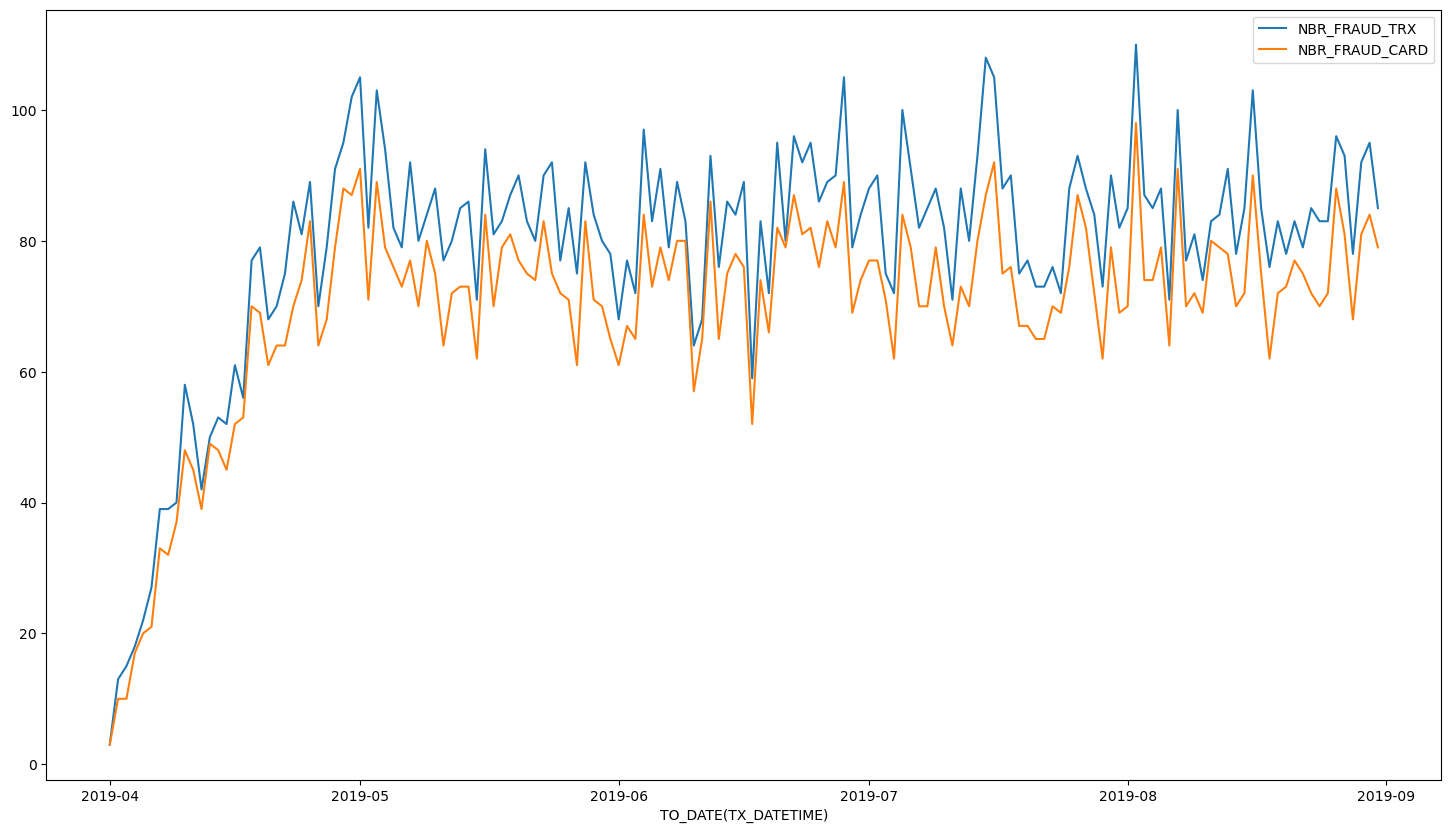

In [9]:
pd_day_by_card = df_cust_trx_fraud.filter(F.col("TX_FRAUD") == 1)\
                             .group_by(F.to_date(F.col("TX_DATETIME"))).agg([F.sum(F.col("TX_FRAUD")).as_("NBR_FRAUD_TRX"), F.count_distinct(F.col("CUSTOMER_ID")).as_("NBR_FRAUD_CARD")])\
                             .sort(F.col("TO_DATE(TX_DATETIME)")).to_pandas()

pd_day_by_card.plot( x="TO_DATE(TX_DATETIME)", y=["NBR_FRAUD_TRX", "NBR_FRAUD_CARD"])

## Feature Engineering
### Date and time transformations

We will create two new binary features from the transaction dates and times:

* The first will characterize whether a transaction occurs during a weekday (value 0) or a weekend (1), and will be called TX_DURING_WEEKEND
* The second will characterize whether a transaction occurs during the day (0) or during the night (1). The night is defined as hours that are between 20pm and 6am. It will be called TX_DURING_NIGHT.

This can be done using the built in date functions in Snowflake that are exposed in the Snowpark API and will be based on the **TX_DATETIME** column, as illustrated in the image below.

![Figure2](images/figure2.png)

In [10]:
df_date_time_feat = df_cust_trx_fraud.with_columns(["TX_DURING_WEEKEND",  "TX_DURING_NIGHT"],\
                                            [F.iff((F.dayofweek(F.col("TX_DATETIME")) == F.lit(6)) | (F.dayofweek(F.col("TX_DATETIME")) == F.lit(0)), F.lit(1), F.lit(0)),\
                                             F.iff((F.hour(F.col("TX_DATETIME")) < F.lit(6)) | (F.hour(F.col("TX_DATETIME")) > F.lit(20)), F.lit(1), F.lit(0))])

df_date_time_feat.sort(F.col("TRANSACTION_ID")).show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRANSACTION_ID"  |"TX_DATETIME"        |"CUSTOMER_ID"  |"TERMINAL_ID"  |"TX_AMOUNT"  |"TX_TIME_SECONDS"  |"TX_TIME_DAYS"  |"TX_FRAUD"  |"TX_FRAUD_SCENARIO"  |"TX_DURING_WEEKEND"  |"TX_DURING_NIGHT"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|0                 |2019-04-01 00:00:31  |596            |3156           |57.16        |31                 |0               |0           |0                    |0                    |1                  |
|1                 |2019-04-01 00:02:10  |4961           |3412           |81.51        |130                |0               |0           |0                    |0                    |1     

Is there differences between the number of fraud cases during weekdays/weekdays and day/Night?

In [11]:
window = Window.partition_by(F.col("TX_DURING_WEEKEND"), F.col("TX_DURING_NIGHT"))

df_date_time_feat.group_by(F.col("TX_DURING_WEEKEND"),F.col("TX_DURING_NIGHT"),F.col("TX_FRAUD"))\
                    .count().sort(F.col("TX_DURING_WEEKEND"), F.col("TX_DURING_NIGHT"), F.col("TX_FRAUD"))\
                    .select(F.col("TX_DURING_WEEKEND"), F.col("TX_DURING_NIGHT"), F.col("TX_FRAUD"), (F.call_builtin("RATIO_TO_REPORT", F.col("COUNT")).over(window) * 100).as_("percentage") )\
                    .sort(F.col("TX_DURING_WEEKEND"), F.col("TX_DURING_NIGHT"), F.col("TX_FRAUD")).show()

-----------------------------------------------------------------------
|"TX_DURING_WEEKEND"  |"TX_DURING_NIGHT"  |"TX_FRAUD"  |"PERCENTAGE"  |
-----------------------------------------------------------------------
|0                    |0                  |0           |99.174600     |
|0                    |0                  |1           |0.825400      |
|0                    |1                  |0           |99.161100     |
|0                    |1                  |1           |0.838900      |
|1                    |0                  |0           |99.179000     |
|1                    |0                  |1           |0.821000      |
|1                    |1                  |0           |99.160900     |
|1                    |1                  |1           |0.839100      |
-----------------------------------------------------------------------



We can see that basicly the number of fradulent transactions are the same during the days

### Customer spending behaviour transformations

We will compute two customer spending behaviour features.

The first feature will be the number of transactions that occur within a time window (Frequency). The second will be the average amount spent in these transactions (Monetary value). The time windows will be set to one, seven, and thirty days. 

The values is to be calculated based on day level where our transactions is on seconds level, the table below show a example of the output for the 1 day window.

|CUSTOMER_ID|TX_DATETIME|TX_AMOUNT|AVG 1 DAY WIN|NBR TRX  1 DAY WIN|
|:---|:---|:---|:---|:---|
|0|2019-04-01 07:19:05.000|123.59|123.59|1|
|0|2019-04-01 18:00:16.000|77.34|100.465|2|
|0|2019-04-01 19:02:02.000|46.51|82.48|3|
|0|2019-04-02 08:51:06.000|54.72|59.523333333|4|
|0|2019-04-02 14:05:38.000|63.3|60.4675|5|
|0|2019-04-02 15:13:02.000|32.35|54.844|6|
|0|2019-04-02 15:46:51.000|13.59|47.968333333|7|
|0|2019-04-02 20:24:47.000|51.89|43.17|8|
|0|2019-04-03 07:41:24.000|93.26|51.518333333|6|

Since we want to aggregate by day and also take include dates that has no transactions (so our windows are real days) we need to first create a new data frame that has for each customer one row for each date between the minimum transaction date and maximum transaction date. Snowpark has a function, **range** , that can be used to generate n number of rows. Since we want to generate a row for each date between minimum and maximum we need to calculate that first. Once we have that dataframe we can do a cross join with our **CUSTOMER** table to create a new dataframe that has now one row for each date between the minimum transaction date and maximum transaction date and customer, as illustrated in the image below.

![Figure3](images/figure3.png)

In [12]:
date_info = df_cust_trx_fraud.select(F.min(F.col("TX_DATETIME")).as_("END_DATE"), F.datediff("DAY", F.col("END_DATE"), F.max(F.col("TX_DATETIME"))).as_("NO_DAYS")).to_pandas()
days = int(date_info['NO_DAYS'].values[0])
start_date = str(date_info['END_DATE'].values[0].astype('datetime64[D]'))

# Create a dataframe with one row for each date between the min and max transaction date
df_days = session.range(days).with_column("TX_DATE", F.to_date(F.dateadd("DAY", F.call_builtin("SEQ4"), F.lit(start_date))))

# Since we aggregate by customer and day and not all customers have transactions for all dates we cross join our date dataframe with our 
# customer table so each customer witll have one row for each date
df_customers = session.table("CUSTOMERS").select("CUSTOMER_ID")
df_cust_day = df_days.join(df_customers)

In [13]:
df_cust_day.show()

-------------------------------------
|"ID"  |"TX_DATE"   |"CUSTOMER_ID"  |
-------------------------------------
|0     |2019-04-01  |0              |
|1     |2019-04-02  |0              |
|2     |2019-04-03  |0              |
|3     |2019-04-04  |0              |
|4     |2019-04-05  |0              |
|5     |2019-04-06  |0              |
|6     |2019-04-07  |0              |
|7     |2019-04-08  |0              |
|8     |2019-04-09  |0              |
|9     |2019-04-10  |0              |
-------------------------------------



We can now use the new data frame, **df_cust_day**, to aggregate the number of transaction and transaction amount by day, for days that a customer has no transaction we will use 0. The picture below illustrates what we are doing.

Earlier in the data understanding part we used **call_builtin** to use a Snowflake functions that is not exposed in the SNowpark API, we can also use **builtin** to assign the function to a variable that we then can use instead how having to write call_builtin each time.



![Figure4](images/figure4.png)

In [14]:
zero_if_null = F.builtin("ZEROIFNULL") # Snowpark does not expose ZEROIFNULL but we can use the call_builtin function for that or the builtin to add it to a variable that can be used in our code

df_cust_trx_day = df_cust_trx_fraud.join(df_cust_day, (df_cust_trx_fraud.col("CUSTOMER_ID") == df_cust_day.col("CUSTOMER_ID")) & (F.to_date(df_cust_trx_fraud.col("TX_DATETIME")) == df_cust_day.col("TX_DATE")), "rightouter") \
            .select(df_cust_day.col("CUSTOMER_ID").as_("CUSTOMER_ID"),\
                    df_cust_day.col("TX_DATE"),\
                    zero_if_null(df_cust_trx_fraud.col("TX_AMOUNT")).as_("TX_AMOUNT"),\
                    F.iff(F.col("TX_AMOUNT") > F.lit(0), F.lit(1), F.lit(0)).as_("NO_TRX"))\
                .group_by(F.col("CUSTOMER_ID"), F.col("TX_DATE"))\
                .agg([F.sum(F.col("TX_AMOUNT")).as_("TOT_AMOUNT"), F.sum(F.col("NO_TRX")).as_("NO_TRX")])


Now when we have the number of transactions and amount by customer and day we can aggregate by our windows (1, 7 and 30 days).

For getting values previous day we will use the **lag** function since it's only one value we want and for 7 and 30 days we will use sum over a window. Since we do not want to include future values we will not include the current day in the windows.

![Figure5](images/figure5.png)

In [15]:
cust_date = Window.partition_by(F.col("customer_id")).orderBy(F.col("TX_DATE"))
win_7d_cust = cust_date.rowsBetween(-7, -1)
win_30d_cust = cust_date.rowsBetween(-30, -1)

df_cust_feat_day = df_cust_trx_day.select(F.col("TX_DATE"),F.col("CUSTOMER_ID"),F.col("NO_TRX"),F.col("TOT_AMOUNT"),
                              F.lag(F.col("NO_TRX"),1).over(cust_date).as_("CUST_TX_PREV_1"),
                              F.sum(F.col("NO_TRX")).over(win_7d_cust).as_("CUST_TX_PREV_7"),
                              F.sum(F.col("NO_TRX")).over(win_30d_cust).as_("CUST_TX_PREV_30"),
                              F.lag(F.col("TOT_AMOUNT"),1).over(cust_date).as_("CUST_TOT_AMT_PREV_1"),
                              F.sum(F.col("TOT_AMOUNT")).over(win_7d_cust).as_("CUST_TOT_AMT_PREV_7"),
                              F.sum(F.col("TOT_AMOUNT")).over(win_30d_cust).as_("CUST_TOT_AMT_PREV_30"))

In [16]:
df_cust_feat_day.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TX_DATE"   |"CUSTOMER_ID"  |"NO_TRX"  |"TOT_AMOUNT"  |"CUST_TX_PREV_1"  |"CUST_TX_PREV_7"  |"CUST_TX_PREV_30"  |"CUST_TOT_AMT_PREV_1"  |"CUST_TOT_AMT_PREV_7"  |"CUST_TOT_AMT_PREV_30"  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|2019-04-01  |19             |0         |0.0           |NULL              |NULL              |NULL               |NULL                   |NULL                   |NULL                    |
|2019-04-02  |19             |1         |18.88         |0                 |0                 |0                  |0.0                    |0.0                    |0.0                     |
|2019-04-03  |19             |0         |0.0           |1   

Now we know for each customer and day the number of transactions and amount for previous 1, 7 and 30 days and we add that to our transactions.

In this step we will also use a window function to count the number of transactions and total amount for the current date, in order to only include the previous transactions for the same date we will create a partion key that consists of transaction date and customer id. By using that we get a rolling sum of all previous rows that is for the same date and customer.

![Figure6](images/figure6.png)

In [17]:
win_cur_date = Window.partition_by(F.col("PARTITION_KEY")).order_by(F.col("TX_DATETIME")).rangeBetween(Window.unboundedPreceding,Window.currentRow)

df_cust_behaviur_feat = df_date_time_feat.join(df_cust_feat_day, (df_date_time_feat.col("CUSTOMER_ID") == df_cust_feat_day.col("CUSTOMER_ID")) & \
                                             (F.to_date(df_date_time_feat.col("TX_DATETIME")) == df_cust_feat_day.col("TX_DATE")))\
        .with_column("PARTITION_KEY", F.concat(df_date_time_feat.col("CUSTOMER_ID"), F.to_date(df_date_time_feat.col("TX_DATETIME"))))\
        .with_columns(["CUR_DAY_TRX",\
                         "CUR_DAY_AMT"],\
                      [F.count(df_date_time_feat.col("CUSTOMER_ID")).over(win_cur_date), \
                      F.sum(df_date_time_feat.col("TX_AMOUNT")).over(win_cur_date)])\
        .select(df_date_time_feat.col("TRANSACTION_ID"), \
                df_date_time_feat.col("CUSTOMER_ID").as_("CUSTOMER_ID"), \
                df_date_time_feat.col("TERMINAL_ID"),\
                df_date_time_feat.col("TX_DATETIME").as_("TX_DATETIME"), \
                df_date_time_feat.col("TX_AMOUNT"),\
                df_date_time_feat.col("TX_TIME_SECONDS"),\
                df_date_time_feat.col("TX_TIME_DAYS"), \
                df_date_time_feat.col("TX_FRAUD"),\
                df_date_time_feat.col("TX_FRAUD_SCENARIO"),\
                df_date_time_feat.col("TX_DURING_WEEKEND"), \
                df_date_time_feat.col("TX_DURING_NIGHT"),\
                (zero_if_null(df_cust_feat_day.col("CUST_TX_PREV_1")) + F.col("CUR_DAY_TRX")).as_("CUST_CNT_TX_1"),\
                ((zero_if_null(df_cust_feat_day.col("CUST_TOT_AMT_PREV_1")) + F.col("CUR_DAY_AMT")) / F.col("CUST_CNT_TX_1")).as_("CUST_AVG_AMOUNT_1"), \
                (zero_if_null(df_cust_feat_day.col("CUST_TX_PREV_7")) + F.col("CUR_DAY_TRX")).as_("CUST_CNT_TX_7"),\
                ((zero_if_null(df_cust_feat_day.col("CUST_TOT_AMT_PREV_7")) + F.col("CUR_DAY_AMT")) / F.col("CUST_CNT_TX_7")).as_("CUST_AVG_AMOUNT_7"),\
                (zero_if_null(df_cust_feat_day.col("CUST_TX_PREV_30")) + F.col("CUR_DAY_TRX")).as_("CUST_CNT_TX_30"),\
                ((zero_if_null(df_cust_feat_day.col("CUST_TOT_AMT_PREV_30")) + F.col("CUR_DAY_AMT")) / F.col("CUST_CNT_TX_30")).as_("CUST_AVG_AMOUNT_30"))

In [18]:
df_cust_behaviur_feat.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRANSACTION_ID"  |"CUSTOMER_ID"  |"TERMINAL_ID"  |"TX_DATETIME"        |"TX_AMOUNT"  |"TX_TIME_SECONDS"  |"TX_TIME_DAYS"  |"TX_FRAUD"  |"TX_FRAUD_SCENARIO"  |"TX_DURING_WEEKEND"  |"TX_DURING_NIGHT"  |"CUST_CNT_TX_1"  |"CUST_AVG_AMOUNT_1"  |"CUST_CNT_TX_7"  |"CUST_AVG_AMOUNT_7"  |"CUST_CNT_TX_30"  |"CUST_AVG_AMOUNT_30"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|0                 |596  

### Terminal ID transformations

The main goal with the Terminal ID transformations will be to extract a risk score, that assesses the exposure of a given terminal ID to fraudulent transactions. The risk score will be defined as the average number of fraudulent transactions that occurred on a terminal ID over a time window. As for customer ID transformations, we will use three window sizes, of 1, 7, and 30 days.

Contrary to customer ID transformations, the time windows will not directly precede a given transaction. Instead, they will be shifted back by a delay period. The delay period accounts for the fact that, in practice, the fraudulent transactions are only discovered after a fraud investigation or a customer complaint. Hence, the fraudulent labels, which are needed to compute the risk score, are only available after this delay period. To a first approximation, this delay period will be set to one week.

Part from above the logic is rather similar to how we calculated for customer.

In [19]:
# Since we aggregate by terminal and day and not all terminals have transactions for all dates we cross join our date dataframe with our terminal table so each terminal will have one row for each date
df_terminals = session.table("TERMINALS").select("TERMINAL_ID")
df_term_day = df_days.join(df_terminals)

# Aggregate number of transactions and amount by terminal and date, for dates where a terminal do not have any ttransactions we ad a 0
df_term_trx_by_day = df_cust_trx_fraud.join(df_term_day, (df_cust_trx_fraud.col("TERMINAL_ID") == df_term_day.col("TERMINAL_ID"))\
                    & (F.to_date(df_cust_trx_fraud.col("TX_DATETIME")) == df_term_day.col("TX_DATE")), "rightouter")\
                .select(df_term_day.col("TERMINAL_ID").as_("TERMINAL_ID"),\
                        df_term_day.col("TX_DATE"), \
                        zero_if_null(df_cust_trx_fraud.col("TX_FRAUD")).as_("NB_FRAUD"), \
                        F.when(F.is_null(df_cust_trx_fraud.col("TX_FRAUD")), F.lit(0)).otherwise(F.lit(1)).as_("NO_TRX")) \
                .groupBy(F.col("TERMINAL_ID"), F.col("TX_DATE"))\
                .agg([F.sum(F.col("NB_FRAUD")).as_("NB_FRAUD"), F.sum(F.col("NO_TRX")).as_("NO_TRX")])

# Aggregate by our windows.
term_date = Window.partitionBy(F.col("TERMINAL_ID")).orderBy(F.col("TX_DATE"))
win_delay = term_date.rowsBetween(-7, -1) 
win_1d_term = term_date.rowsBetween(-8, -1) # We need to add the Delay period to our windows
win_7d_term = term_date.rowsBetween(-14, -1)
win_30d_term = term_date.rowsBetween(-37, -1)

df_term_feat_day = df_term_trx_by_day.select(F.col("TX_DATE"),F.col("TERMINAL_ID"),F.col("NO_TRX"), F.col("NB_FRAUD"),
                              F.sum(F.col("NB_FRAUD")).over(win_delay).as_("NB_FRAUD_DELAY"),
                              F.sum(F.col("NO_TRX")).over(win_delay).as_("NB_TX_DELAY"),
                              F.sum(F.col("NO_TRX")).over(win_1d_term).as_("NB_TX_DELAY_WINDOW_1"),
                              F.sum(F.col("NO_TRX")).over(win_1d_term).as_("NB_TX_DELAY_WINDOW_7"),
                              F.sum(F.col("NO_TRX")).over(win_30d_term).as_("NB_TX_DELAY_WINDOW_30"),
                              F.sum(F.col("NB_FRAUD")).over(win_1d_term).as_("NB_FRAUD_DELAY_WINDOW_1"),
                              F.sum(F.col("NB_FRAUD")).over(win_1d_term).as_("NB_FRAUD_DELAY_WINDOW_7"),
                              F.sum(F.col("NB_FRAUD")).over(win_30d_term).as_("NB_FRAUD_DELAY_WINDOW_30"))

df_term_behaviur_feat = df_cust_behaviur_feat.join(df_term_feat_day, (df_cust_behaviur_feat.col("TERMINAL_ID") == df_term_feat_day.col("TERMINAL_ID")) &\
                                                 (F.to_date(df_cust_behaviur_feat.col("TX_DATETIME")) == df_term_feat_day.col("TX_DATE")))\
            .with_columns(["PARTITION_KEY",\
                             "CUR_DAY_TRX",\
                             "CUR_DAY_FRAUD"],\
                         [F.concat(df_cust_behaviur_feat.col("TERMINAL_ID"), F.to_date(df_cust_behaviur_feat.col("TX_DATETIME"))),\
                             F.count(df_cust_behaviur_feat.col("TERMINAL_ID")).over(win_cur_date),\
                             F.sum(df_cust_behaviur_feat.col("TX_FRAUD")).over(win_cur_date)]\
                          )\
             .with_columns(["NB_TX_DELAY", \
                              "NB_FRAUD_DELAY",\
                              "NB_TX_DELAY_WINDOW_1",\
                              "NB_FRAUD_DELAY_WINDOW_1",\
                              "NB_TX_DELAY_WINDOW_7",\
                              "NB_FRAUD_DELAY_WINDOW_7",\
                              "NB_TX_DELAY_WINDOW_30",\
                              "NB_FRAUD_DELAY_WINDOW_30"],\
                           [df_term_feat_day.col("NB_TX_DELAY") + F.col("CUR_DAY_TRX"),\
                               F.col("NB_FRAUD_DELAY") +  F.col("CUR_DAY_FRAUD"),\
                               F.col("NB_TX_DELAY_WINDOW_1") + F.col("CUR_DAY_TRX"),\
                               F.col("NB_FRAUD_DELAY_WINDOW_1") + F.col("CUR_DAY_FRAUD"),\
                               F.col("NB_TX_DELAY_WINDOW_7") + F.col("CUR_DAY_TRX"),\
                               F.col("NB_FRAUD_DELAY_WINDOW_7") + F.col("CUR_DAY_FRAUD"),\
                               F.col("NB_TX_DELAY_WINDOW_30") + F.col("CUR_DAY_TRX"),\
                               F.col("NB_FRAUD_DELAY_WINDOW_30") + F.col("CUR_DAY_FRAUD")])\
             .select(df_cust_behaviur_feat.col("TRANSACTION_ID"), \
                     df_cust_behaviur_feat.col("TX_DATETIME").as_("TX_DATETIME"),\
                     df_cust_behaviur_feat.col("CUSTOMER_ID").as_("CUSTOMER_ID"), \
                     df_cust_behaviur_feat.col("TERMINAL_ID").as_("TERMINAL_ID"),\
                     df_cust_behaviur_feat.col("TX_TIME_SECONDS"), \
                     df_cust_behaviur_feat.col("TX_TIME_DAYS"), \
                     df_cust_behaviur_feat.col("TX_AMOUNT"), \
                     df_cust_behaviur_feat.col("TX_FRAUD"), \
                     df_cust_behaviur_feat.col("TX_FRAUD_SCENARIO"),\
                     df_cust_behaviur_feat.col("TX_DURING_WEEKEND"), \
                     df_cust_behaviur_feat.col("TX_DURING_NIGHT"),\
                     df_cust_behaviur_feat.col("CUST_AVG_AMOUNT_1"),\
                     df_cust_behaviur_feat.col("CUST_CNT_TX_1"), \
                     df_cust_behaviur_feat.col("CUST_AVG_AMOUNT_7"),\
                     df_cust_behaviur_feat.col("CUST_CNT_TX_7"), \
                     df_cust_behaviur_feat.col("CUST_AVG_AMOUNT_30"),\
                     df_cust_behaviur_feat.col("CUST_CNT_TX_30"),\
                     (F.col("NB_TX_DELAY_WINDOW_1") - F.col("NB_TX_DELAY")).as_("NB_TX_WINDOW_1"),\
                     F.iff(F.col("NB_FRAUD_DELAY_WINDOW_1") - F.col("NB_FRAUD_DELAY") > 0, \
                             (F.col("NB_FRAUD_DELAY_WINDOW_1") - F.col("NB_FRAUD_DELAY")) / F.col("NB_TX_WINDOW_1"), F.lit(0)).as_("TERM_RISK_1"),\
                     (F.col("NB_TX_DELAY_WINDOW_7") - F.col("NB_TX_DELAY")).as_("NB_TX_WINDOW_7"),\
                     F.iff(F.col("NB_FRAUD_DELAY_WINDOW_7") - F.col("NB_FRAUD_DELAY") > 0, \
                             (F.col("NB_FRAUD_DELAY_WINDOW_7") - F.col("NB_FRAUD_DELAY")) / F.col("NB_TX_WINDOW_7"), F.lit(0)).as_("TERM_RISK_7"),\
                     (F.col("NB_TX_DELAY_WINDOW_30") - F.col("NB_TX_DELAY")).as_("NB_TX_WINDOW_30"),\
                     F.iff(F.col("NB_FRAUD_DELAY_WINDOW_30") - F.col("NB_FRAUD_DELAY") > 0, \
                             (F.col("NB_FRAUD_DELAY_WINDOW_30") - F.col("NB_FRAUD_DELAY"))  / F.col("NB_TX_WINDOW_30"), F.lit(0)).as_("TERM_RISK_30"))

In [20]:
df_term_behaviur_feat.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRANSACTION_ID"  |"TX_DATETIME"        |"CUSTOMER_ID"  |"TERMINAL_ID"  |"TX_TIME_SECONDS"  |"TX_TIME_DAYS"  |"TX_AMOUNT"  |"TX_FRAUD"  |"TX_FRAUD_SCENARIO"  |"TX_DURING_WEEKEND"  |"TX_DURING_NIGHT"  |"CUST_AVG_AMOUNT_1"  |"CUST_CNT_TX_1"  |"CUST_AVG_AMOUNT_7"  |"CUST_CNT_TX_7"  |"CUST_AVG_AMOUNT_30"  |"CUST_CNT_TX_30"  |"NB_TX_WINDOW_1"  |"TERM_RISK_1"  |"NB_TX_WINDOW_7"  |"TERM_RISK_7"  |"NB_TX_WINDOW_30"  |"TERM_RISK_30"  |
----------------------------------------------------------------------------------------------------------------------------------------

We now have our new features and can save it into a new table that we then can use for traing our model for predicting fraud.

Start by checking the schema of our new dataframe and decide if we will keep all columns.

In [21]:
for col in df_term_behaviur_feat.schema.fields:
    print(f"{col.name}, Nullable: {col.nullable}, {col.datatype}")

TRANSACTION_ID, Nullable: True, LongType()
TX_DATETIME, Nullable: True, TimestampType()
CUSTOMER_ID, Nullable: True, LongType()
TERMINAL_ID, Nullable: True, LongType()
TX_TIME_SECONDS, Nullable: True, LongType()
TX_TIME_DAYS, Nullable: True, LongType()
TX_AMOUNT, Nullable: True, DoubleType()
TX_FRAUD, Nullable: True, LongType()
TX_FRAUD_SCENARIO, Nullable: True, LongType()
TX_DURING_WEEKEND, Nullable: False, LongType()
TX_DURING_NIGHT, Nullable: False, LongType()
CUST_AVG_AMOUNT_1, Nullable: True, DoubleType()
CUST_CNT_TX_1, Nullable: False, LongType()
CUST_AVG_AMOUNT_7, Nullable: True, DoubleType()
CUST_CNT_TX_7, Nullable: False, LongType()
CUST_AVG_AMOUNT_30, Nullable: True, DoubleType()
CUST_CNT_TX_30, Nullable: False, LongType()
NB_TX_WINDOW_1, Nullable: True, LongType()
TERM_RISK_1, Nullable: True, DecimalType(38, 6)
NB_TX_WINDOW_7, Nullable: True, LongType()
TERM_RISK_7, Nullable: True, DecimalType(38, 6)
NB_TX_WINDOW_30, Nullable: True, LongType()
TERM_RISK_30, Nullable: True, D

As mentioned we are not actually executing anything in Snowflake, unless when using .show(), and has just created a execution plan.

We can get the SQL needed to prefrom all our steps by calling **queries**

In [22]:
df_term_behaviur_feat.queries

{'queries': ['SELECT "TRANSACTION_ID", "TX_DATETIME" AS "TX_DATETIME", "CUSTOMER_ID" AS "CUSTOMER_ID", "l_w130_TERMINAL_ID" AS "TERMINAL_ID", "TX_TIME_SECONDS", "TX_TIME_DAYS", "TX_AMOUNT", "TX_FRAUD", "TX_FRAUD_SCENARIO", "TX_DURING_WEEKEND", "TX_DURING_NIGHT", "CUST_AVG_AMOUNT_1", "CUST_CNT_TX_1", "CUST_AVG_AMOUNT_7", "CUST_CNT_TX_7", "CUST_AVG_AMOUNT_30", "CUST_CNT_TX_30", ("NB_TX_DELAY_WINDOW_1" - "NB_TX_DELAY") AS "NB_TX_WINDOW_1", iff((("NB_FRAUD_DELAY_WINDOW_1" - "NB_FRAUD_DELAY") > 0 :: INT), (("NB_FRAUD_DELAY_WINDOW_1" - "NB_FRAUD_DELAY") / "NB_TX_WINDOW_1"), 0) AS "TERM_RISK_1", ("NB_TX_DELAY_WINDOW_7" - "NB_TX_DELAY") AS "NB_TX_WINDOW_7", iff((("NB_FRAUD_DELAY_WINDOW_7" - "NB_FRAUD_DELAY") > 0 :: INT), (("NB_FRAUD_DELAY_WINDOW_7" - "NB_FRAUD_DELAY") / "NB_TX_WINDOW_7"), 0) AS "TERM_RISK_7", ("NB_TX_DELAY_WINDOW_30" - "NB_TX_DELAY") AS "NB_TX_WINDOW_30", iff((("NB_FRAUD_DELAY_WINDOW_30" - "NB_FRAUD_DELAY") > 0 :: INT), (("NB_FRAUD_DELAY_WINDOW_30" - "NB_FRAUD_DELAY") / "NB_TX

We can quicly scale up our Warhouse (compute) before we load our new table and after we done the load we can scale it down again.

By creating a function for it we can simplify the code and make it easier for the developers.

In [23]:
def scale_wh(sess, wh, size):
    if (len(wh) == 0): 
        return false
    if (len(size) == 0):
        return false
   
    alter_SQL = "ALTER WAREHOUSE " + wh + " SET WAREHOUSE_SIZE = " + size
    sess.sql(alter_SQL).collect()
    return True


In [24]:
scale_wh(session, session.get_current_warehouse(), "LARGE")

True

We we run **saveAsTable** Snowpark will generate the SQL for all the previous step, execute it in Snowflake and store the result in the table **customer_trx_fraud_features**.

In [25]:
df_term_behaviur_feat.write.mode("overwrite").save_as_table("customer_trx_fraud_features")

In [26]:
scale_wh(session,session.get_current_warehouse(), "SMALL")

True